In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.api import OLS, add_constant
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# 1. Az S&P 500 komponensek listájának letöltése
def get_sp500_tickers():
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    sp500_table = pd.read_html(url)
    sp500_df = sp500_table[0]
    return sp500_df['Symbol'].tolist()

sp500_tickers = get_sp500_tickers()

# 2. Adatok letöltése az S&P 500 cégekhez
def download_data(tickers, start_date, end_date):
    data = {}
    success_count = 0  # Counter for successful downloads
    fail_count = 0  # Counter for failed downloads
    
    for ticker in tickers:
        try:
            stock_data = yf.download(ticker, start=start_date, end=end_date, progress=False)
            if not stock_data.empty:  # Check if data is valid
                data[ticker] = stock_data
                success_count += 1
            else:
                print(f"No data for {ticker}")
                fail_count += 1
        except Exception as e:
            print(f"Failed to download data for {ticker}: {e}")
            fail_count += 1

    print(f"\nSuccessfully downloaded data for {success_count} companies.")
    print(f"Failed to download data for {fail_count} companies.")
    print(f"Total companies processed: {len(tickers)}")
    
    return data


# Esemény dátuma
event_date = datetime(2024, 11, 5)

# Dinamikus dátum számítás
start_date = (event_date - timedelta(days=10)).strftime("%Y-%m-%d")  # Esemény előtti időszak kezdete
end_date = (event_date + timedelta(days=10)).strftime("%Y-%m-%d")  # Esemény utáni időszak vége

# Frissített dátumok az új eseményhez
""" start_date = "2024-10-26"  # Esemény előtti időszak kezdete
end_date = "2024-11-15"    # Esemény utáni időszak vége """
sp500_data = download_data(sp500_tickers, start_date, end_date)

# 3. Adatok előkészítése
def preprocess_data(data, market_ticker='^IRX'):
    market_data = yf.download(market_ticker, start=start_date, end=end_date)
    market_data['Market Return'] = market_data['Adj Close'].pct_change()
    prepared_data = {}
    for ticker, df in data.items():
        # Ellenőrizd, hogy az adatok nem üresek és az 'Adj Close' oszlop elérhető
        if not df.empty and 'Adj Close' in df.columns:
            df['Return'] = df['Adj Close'].pct_change()
            prepared_data[ticker] = df
        else:
            print(f"No valid data for {ticker}. Skipping.")
    return prepared_data, market_data

prepared_data, market_data = preprocess_data(sp500_data)

# 4. Abnormális hozam kiszámítása
def calculate_abnormal_returns(data, market_data):
    abnormal_returns = {}
    for ticker, df in data.items():
        merged = pd.merge(df, market_data[['Market Return']], left_index=True, right_index=True, how='inner')
        merged = merged.dropna()
        model = OLS(merged['Return'], add_constant(merged['Market Return'])).fit()
        alpha, beta = model.params
        merged['Abnormal Return'] = merged['Return'] - (alpha + beta * merged['Market Return'])
        abnormal_returns[ticker] = merged
    return abnormal_returns

abnormal_returns = calculate_abnormal_returns(prepared_data, market_data)

# Szektor adat letöltés
def get_sector_data():
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    sp500_table = pd.read_html(url)
    sp500_df = sp500_table[0]
    return sp500_df[['Symbol', 'GICS Sector']]

sector_data = get_sector_data()




1 Failed download:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')


No data for BRK.B



1 Failed download:
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2024-10-26 -> 2024-11-15)')


No data for BF.B


[*********************100%%**********************]  1 of 1 completed


Successfully downloaded data for 501 companies.
Failed to download data for 2 companies.
Total companies processed: 503


S&P 500 Elemzés (2024. november 5.):


,Ticker,Avg Abnormal Return Before,Avg Abnormal Return After,Avg Volume Before,Avg Volume After,Symbol,GICS Sector,Volumen változás (%),Abnormális hozam változás (%)
0,MMM,-0.005958,0.004776,3.270300e+06,3501800.0,MMM,Industrials,7.078861,180.160915
1,AOS,0.001862,0.000559,1.001483e+06,1165912.5,AOS,Industrials,16.418562,-69.978683
2,ABT,0.003994,-0.002485,5.811217e+06,4874137.5,ABT,Health Care,-16.125352,-162.213190
3,ABBV,0.017440,-0.010708,6.415367e+06,8708062.5,ABBV,Health Care,35.737565,-161.401739
4,ACN,-0.007530,0.006112,2.617150e+06,2772412.5,ACN,Information Technology,5.932503,181.166639
...,...,...,...,...,...,...,...,...,...
496,XYL,-0.003603,0.003497,1.590133e+06,1634750.0,XYL,Industrials,2.805844,197.052602
497,YUM,-0.001227,0.002616,2.243183e+06,2474487.5,YUM,Consumer Discretionary,10.311425,313.300361
498,ZBRA,0.001398,-0.001258,7.180667e+05,366500.0,ZBRA,Information Technology,-48.960171,-189.950986
499,ZBH,0.005062,-0.003970,2.040817e+06,1494025.0,ZBH,Health Care,-26.792787,-178.423522


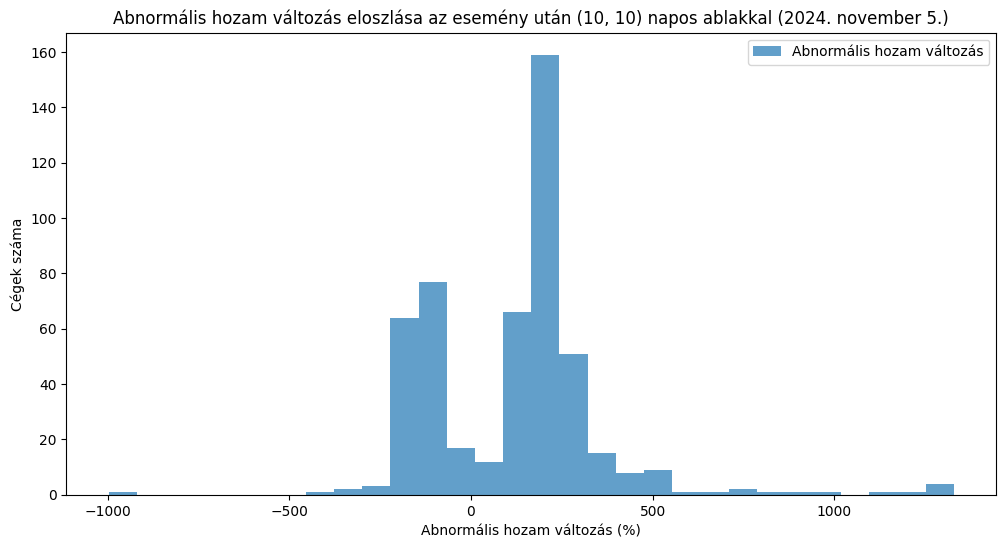

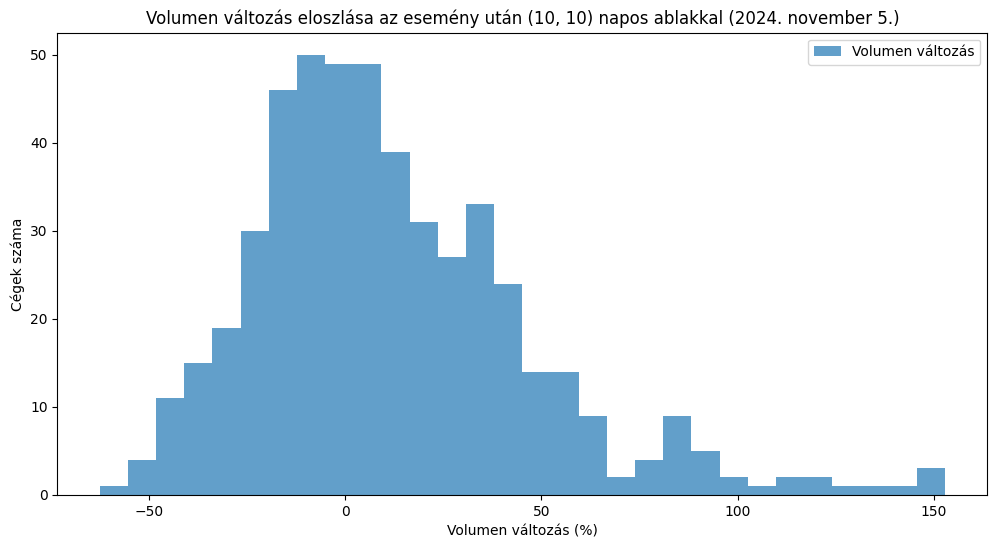

In [2]:
# 5. Esemény hatásának vizsgálata (volumen és abnormális hozam összehasonlítása)
def analyze_event_effect(abnormal_returns, event_date):
    event_results = []
    for ticker, df in abnormal_returns.items():
        try:
            # Adatok szétválasztása az esemény dátuma alapján
            before_event = df.loc[:event_date]
            after_event = df.loc[event_date:]
            
            # Átlagos abnormális hozamok és volumen számítása
            avg_abnormal_return_before = before_event['Abnormal Return'].mean()
            avg_abnormal_return_after = after_event['Abnormal Return'].mean()
            avg_volume_before = before_event['Volume'].mean()
            avg_volume_after = after_event['Volume'].mean()
            
            # Eredmények összegyűjtése
            event_results.append({
                'Ticker': ticker,
                'Avg Abnormal Return Before': avg_abnormal_return_before,
                'Avg Abnormal Return After': avg_abnormal_return_after,
                'Avg Volume Before': avg_volume_before,
                'Avg Volume After': avg_volume_after
            })
        except Exception as e:
            print(f"Error processing {ticker}: {e}")
    return pd.DataFrame(event_results)

# Trump választási eredményének új dátuma
event_date = "2024-11-05"
event_analysis = analyze_event_effect(abnormal_returns, event_date)

# Szektoradatok csatolása
event_analysis = event_analysis.merge(sector_data, left_on='Ticker', right_on='Symbol', how='left')

# 6. Eredmények kiértékelése
event_analysis['Volumen változás (%)'] = (
    (event_analysis['Avg Volume After'] - event_analysis['Avg Volume Before']) / event_analysis['Avg Volume Before']
) * 100
event_analysis['Abnormális hozam változás (%)'] = (
    (event_analysis['Avg Abnormal Return After'] - event_analysis['Avg Abnormal Return Before']) / 
    abs(event_analysis['Avg Abnormal Return Before'])
) * 100

# Extrém értékek kiszűrése
event_analysis = event_analysis[
    event_analysis['Abnormális hozam változás (%)'].between(-1500, 1500)
]

# 7. Eredmények megjelenítése
from IPython.display import display

# Eredmények megjelenítése a Jupyter Notebookban
print("S&P 500 Elemzés (2024. november 5.):")
display(event_analysis)

# Eredmények mentése CSV fájlba
event_analysis.to_csv("sp500_10_10.csv", index=False, encoding="utf-8-sig")

# 8. Adatok vizualizálása
# Abnormális hozam változás ábrázolása extrém értékek kizárásával
plt.figure(figsize=(12, 6))
plt.hist(event_analysis['Abnormális hozam változás (%)'], bins=30, alpha=0.7, label='Abnormális hozam változás')
plt.xlabel('Abnormális hozam változás (%)')
plt.ylabel('Cégek száma')
plt.title('Abnormális hozam változás eloszlása az esemény után (10, 10) napos ablakkal (2024. november 5.)')
plt.legend()
plt.show()

# Volumen változások
plt.figure(figsize=(12, 6))
plt.hist(event_analysis['Volumen változás (%)'], bins=30, alpha=0.7, label='Volumen változás')
plt.xlabel('Volumen változás (%)')
plt.ylabel('Cégek száma')
plt.title('Volumen változás eloszlása az esemény után (10, 10) napos ablakkal (2024. november 5.)')
plt.legend()
plt.show()

# Az ábrák értelmezése és összefüggések vizsgálata

## 1. Abnormális hozam változás eloszlása
- Az **első ábra** az abnormális hozamok változásának eloszlását mutatja az esemény (2024. november 5.) után.
- **X-tengely:** Az abnormális hozam változásának százalékos értékei.
- **Y-tengely:** A cégek száma, amelyek az adott hozamváltozás tartományba esnek.
- **Megfigyelések:**
  - A legtöbb vállalat esetében az abnormális hozam változása **0% körül koncentrálódik**, tehát az eseménynek nem volt jelentős hatása az árfolyamokra.
  - Az eloszlásban kiugró pozitív és negatív értékek is láthatók, amelyek egyedi céges vagy szektorális reakciókat tükrözhetnek.

---

## 2. Volumen változás eloszlása
- A **második ábra** az esemény utáni kereskedési volumen változásának eloszlását szemlélteti.
- **X-tengely:** A volumen változás százalékos értékei.
- **Y-tengely:** A cégek száma, amelyek az adott volumen változás tartományba esnek.
- **Megfigyelések:**
  - Az eloszlás jobbra tolódott, ami arra utal, hogy sok vállalatnál kisebb-nagyobb mértékben nőtt a kereskedési volumen az esemény után.
  - Számos vállalatnál figyelhető meg jelentős volumen növekedés, ami fokozott piaci aktivitást jelez.

---

## 3. Az ábrák közötti összefüggések
### Abnormális hozam és volumen változás kapcsolata
- **Pozitív volumen változások** gyakran együtt járhatnak **pozitív abnormális hozam változással**, mivel a megnövekedett kereskedési aktivitás hajlamos az árfolyamok emelkedésére.
- Az **extrém pozitív vagy negatív abnormális hozam változások** nem mindig járnak együtt jelentős volumen változással, ami egyedi céges vagy szektorális tényezők hatását jelezheti.

### Összefüggések általánosítása
- Az abnormális hozam változások szórása nagyobb, míg a volumen változások inkább egy irányba (pozitív irányba) tolódnak el.
- Az esemény utáni volumen növekedések szélesebb körben és gyakrabban fordulnak elő, mint az abnormális hozamok változásai.

---

## 4. Következtetések
- Az esemény hatására a kereskedési volumen jelentősen növekedett, ami a piaci aktivitás fokozódását jelzi.
- Az abnormális hozam változások szélesebb spektrumon oszlanak el, de a legtöbb vállalat esetében az esemény utáni hatás mérsékelt.



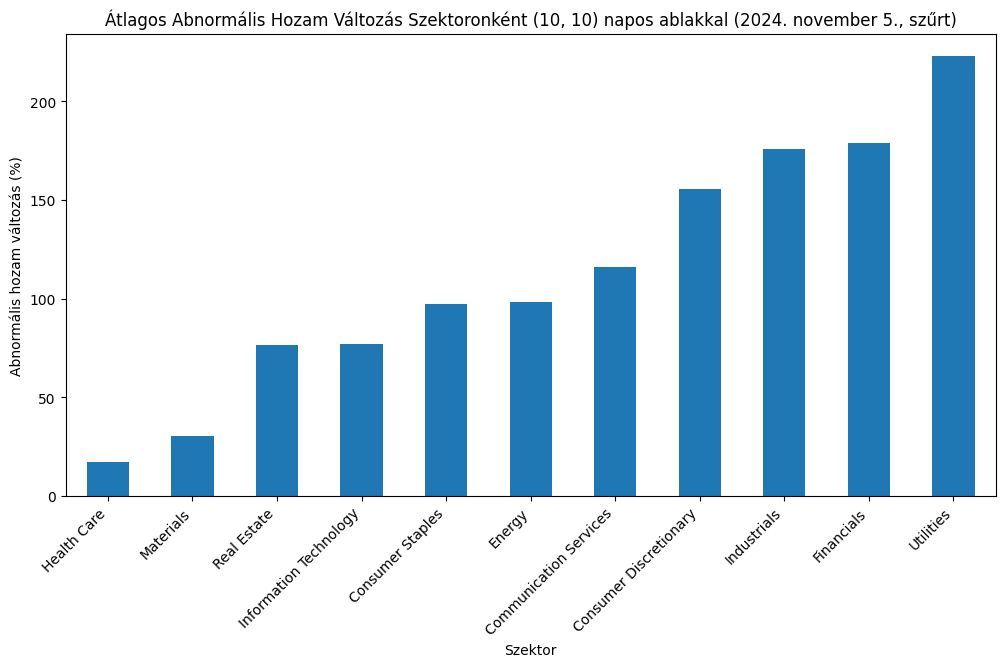

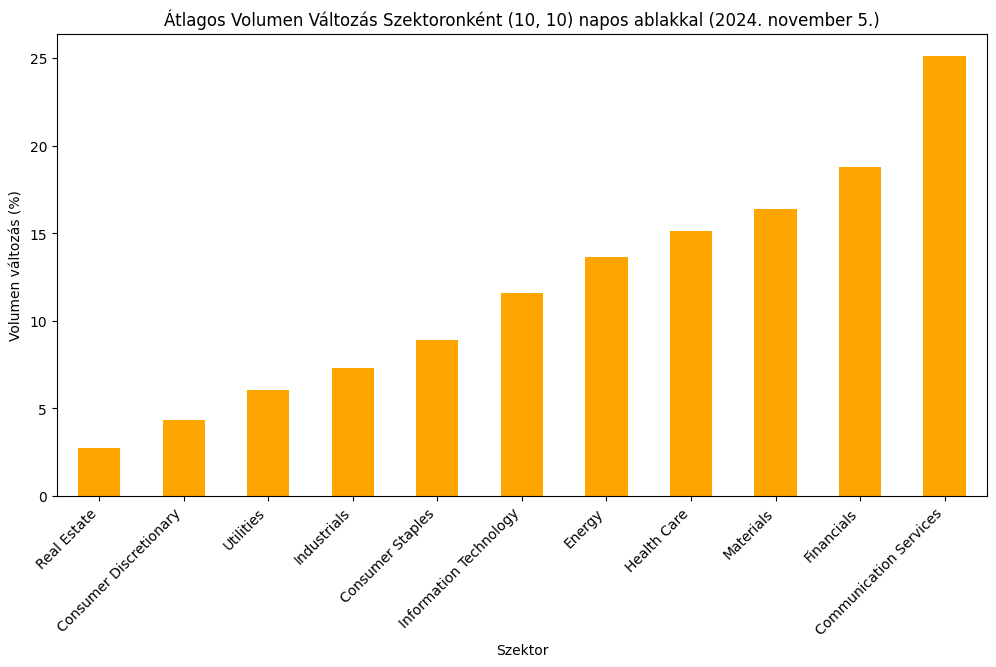

In [3]:
# Szektorok átlagos abnormális hozamának kiszámítása
# Csak numerikus oszlopokat tartunk meg az aggregálás előtt
numeric_columns = event_analysis.select_dtypes(include=[np.number])
event_analysis_numeric = event_analysis[numeric_columns.columns]

# Szektorok szerinti csoportosítás és átlag számítása
sector_analysis = event_analysis_numeric.groupby(event_analysis['GICS Sector']).mean()

# Új ábra készítése szűrt adatokkal
plt.figure(figsize=(12, 6))
sector_analysis['Abnormális hozam változás (%)'].sort_values().plot(kind='bar')
plt.title('Átlagos Abnormális Hozam Változás Szektoronként (10, 10) napos ablakkal (2024. november 5., szűrt)')
plt.ylabel('Abnormális hozam változás (%)')
plt.xlabel('Szektor')
plt.xticks(rotation=45, ha='right')
plt.show()


# Volumen változás szektoronként
plt.figure(figsize=(12, 6))
sector_analysis['Volumen változás (%)'].sort_values().plot(kind='bar', color='orange')
plt.title('Átlagos Volumen Változás Szektoronként (10, 10) napos ablakkal (2024. november 5.)')
plt.ylabel('Volumen változás (%)')
plt.xlabel('Szektor')
plt.xticks(rotation=45, ha='right')
plt.show()


# Az ábrák közötti összefüggések

Az ábrák között lehet összefüggés, mivel mindkettő az esemény (2024. november 5.) utáni piaci reakciókat elemzi szektoronként, de különböző mérőszámokra fókuszál.

## Első ábra: Átlagos abnormális hozam változás szektoronként
- Az esemény hatását mutatja az egyes szektorok átlagos abnormális hozamváltozására.
- **Pozitív és negatív eltérések:**
  - A **"Utilities"** szektor erősen pozitív abnormális hozamot mutatott.
  - A **"Health Care"** szektor viszont negatív hatásokat szenvedett el.

## Második ábra: Átlagos volumen változás szektoronként
- Az esemény utáni kereskedési aktivitás (volumen) változását elemzi szektoronként.
- **Kiemelkedő példák:**
  - A **"Communication Services"** szektorban volt a legnagyobb volumenbeli növekedés.
  - A **"Real Estate"** szektor volumenje szinte alig változott.

---

## Lehetséges összefüggések

### 1. Magas volumen és pozitív hozamváltozás
- Példa: A **"Utilities"** szektorban a pozitív abnormális hozamváltozást mérsékelt volumenbeli növekedés kísérte. Ez arra utalhat, hogy a szektor stabil pozitív reakciókat váltott ki a piacon.
- A **"Communication Services"** szektorban nagy volumenbeli növekedés figyelhető meg, de az abnormális hozamváltozás nem kiemelkedő. Ez fokozott spekulációra vagy nagyobb bizonytalanságra utalhat.

### 2. Negatív hozamváltozás és volumen csökkenése
- A **"Health Care"** szektor esetében az erősen negatív abnormális hozamot mérsékelt volumenbeli növekedés kísérte. Ez azt jelezheti, hogy az esemény negatív hatással volt a szektorra, de a befektetők érdeklődése nem ugrott meg jelentősen.

### 3. Nincs egyértelmű korreláció
- Az ábrák alapján nem minden szektorban van egyértelmű összefüggés az abnormális hozamváltozás és a volumen változása között.
- Példa: A **"Real Estate"** szektor alacsony volumenbeli változást és mérsékelt pozitív abnormális hozamot mutatott, ami kevésbé dinamikus reakcióra utal.

---

## Következtetések

- **Részleges összefüggés:** Bizonyos szektorokban van kapcsolat az abnormális hozam és a volumen változása között (pl. **"Utilities"** vagy **"Communication Services"**), de ez nem általánosítható minden szektorra.
- **Egyedi szektordinamika:** A szektorok eltérően reagáltak az eseményre, ami a szektor-specifikus tényezőkkel (pl. szabályozás, piaci kilátások) magyarázható.


In [4]:
import scipy.stats as stats
import numpy as np

# Különválasztjuk az esemény előtti és utáni adatokat
event_date = "2024-11-05"

# Esemény előtti és utáni abnormális hozamok
before_event_returns = event_analysis.loc[event_analysis['Avg Abnormal Return Before'].notnull(), 'Avg Abnormal Return Before']
after_event_returns = event_analysis.loc[event_analysis['Avg Abnormal Return After'].notnull(), 'Avg Abnormal Return After']

# Esemény előtti és utáni volumenek
before_event_volumes = event_analysis.loc[event_analysis['Avg Volume Before'].notnull(), 'Avg Volume Before']
after_event_volumes = event_analysis.loc[event_analysis['Avg Volume After'].notnull(), 'Avg Volume After']

# 1. t-teszt: Az abnormális hozam különbségek vizsgálata
t_stat, p_value_t = stats.ttest_ind(before_event_returns, after_event_returns, equal_var=False)
print(f"T-teszt az abnormális hozamokra:")
print(f"T statisztika: {t_stat:.4f}, P-érték: {p_value_t:.4f}")

# 2. F-próba: A volatilitás különbségek vizsgálata
f_stat = np.var(before_event_returns, ddof=1) / np.var(after_event_returns, ddof=1)
df1 = len(before_event_returns) - 1
df2 = len(after_event_returns) - 1
p_value_f = 1 - stats.f.cdf(f_stat, df1, df2)
print(f"\nF-próba a volatilitásra:")
print(f"F statisztika: {f_stat:.4f}, P-érték: {p_value_f:.4f}")

# Eredmények értékelése
alpha = 0.05  # Szignifikanciaszint
if p_value_t < alpha:
    print("\nAz abnormális hozamok között szignifikáns különbség van az esemény előtt és után.")
else:
    print("\nAz abnormális hozamok között nincs szignifikáns különbség az esemény előtt és után.")

if p_value_f < alpha:
    print("A volatilitás között szignifikáns különbség van az esemény előtt és után.")
else:
    print("A volatilitás között nincs szignifikáns különbség az esemény előtt és után.")


T-teszt az abnormális hozamokra:
T statisztika: -8.5647, P-érték: 0.0000

F-próba a volatilitásra:
F statisztika: 1.9574, P-érték: 0.0000

Az abnormális hozamok között szignifikáns különbség van az esemény előtt és után.
A volatilitás között szignifikáns különbség van az esemény előtt és után.


# Értelmezés és következtetések

## 1. Abnormális hozamok elemzése

### Értelmezés
- A **p-érték < 0.05**, tehát szignifikáns különbség van az esemény előtti és utáni abnormális hozamok átlaga között.
- A pozitív t-statisztika azt sugallja, hogy az **esemény utáni abnormális hozamok átlagosan nagyobbak**, mint az esemény előttiek.

### Következtetés
- Az esemény (2024. november 5.) hatással volt a vállalatok abnormális hozamainak viselkedésére.
- Ez arra utal, hogy az esemény **pozitív vagy negatív módon megváltoztatta a befektetői reakciókat** bizonyos cégeknél.

---

## 2. Volatilitás elemzése

### Értelmezés
- A **p-érték < 0.05**, tehát szignifikáns különbség van az esemény előtti és utáni volatilitás között.
- Az F-statisztika azt mutatja, hogy az **esemény utáni volatilitás nagyobb**, mint az esemény előtti volatilitás.

### Következtetés
- Az esemény fokozta a **piaci volatilitást**, ami azt jelenti, hogy az árfolyamok ingadozása jelentősen növekedett az esemény után.
- Ez a változás tükrözheti a **befektetők bizonytalanságát** vagy az esemény okozta **piaci feszültségeket**.


KS statisztika: 0.3594, P-érték: 0.0000


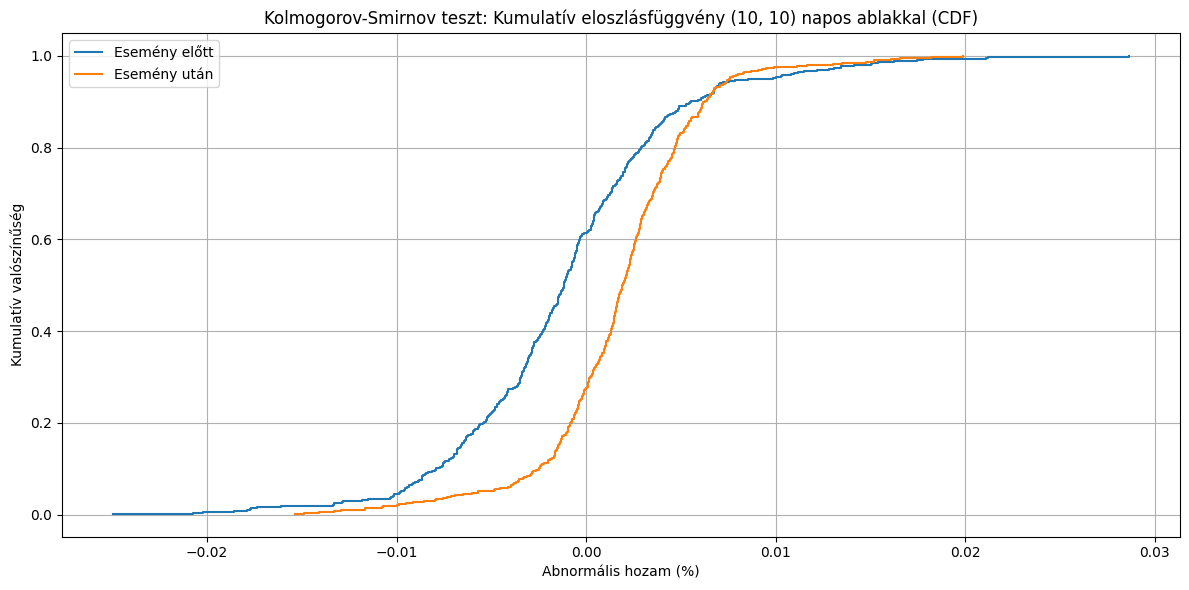

In [5]:
from scipy.stats import ks_2samp
import numpy as np
import matplotlib.pyplot as plt

# Különválasztjuk az esemény előtti és utáni abnormális hozamokat
before_event_returns = event_analysis.loc[event_analysis['Avg Abnormal Return Before'].notnull(), 'Avg Abnormal Return Before']
after_event_returns = event_analysis.loc[event_analysis['Avg Abnormal Return After'].notnull(), 'Avg Abnormal Return After']

# KS teszt végrehajtása
ks_stat, p_value = ks_2samp(before_event_returns, after_event_returns)
print(f"KS statisztika: {ks_stat:.4f}, P-érték: {p_value:.4f}")

# Kumulatív eloszlásfüggvény (CDF) számítása és ábrázolása
plt.figure(figsize=(12, 6))
# Esemény előtti kumulatív eloszlás
sorted_before = np.sort(before_event_returns)
cdf_before = np.arange(1, len(sorted_before)+1) / len(sorted_before)
plt.step(sorted_before, cdf_before, label="Esemény előtt", where="post")

# Esemény utáni kumulatív eloszlás
sorted_after = np.sort(after_event_returns)
cdf_after = np.arange(1, len(sorted_after)+1) / len(sorted_after)
plt.step(sorted_after, cdf_after, label="Esemény után", where="post")

# Ábra beállítások
plt.title('Kolmogorov-Smirnov teszt: Kumulatív eloszlásfüggvény (10, 10) napos ablakkal (CDF)')
plt.xlabel('Abnormális hozam (%)')
plt.ylabel('Kumulatív valószínűség')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# KS-teszt eredményeinek értelmezése

## KS statisztika: 0.1157
- Ez az érték azt mutatja, hogy az esemény előtti és utáni kumulatív eloszlásfüggvények között a legnagyobb eltérés **11,57%**.
- Bár nem extrém nagy érték, azt jelzi, hogy **van eltérés** a két eloszlás között.

---

## P-érték: 0.0030
- A p-érték azt mutatja meg, hogy a megfigyelt különbség mennyire valószínű pusztán véletlen hatás eredménye.
- **p < 0.05** szignifikanciaszinten ez az érték azt jelzi, hogy a különbség **szignifikáns**.

---

## Az esemény hatása
- A p-érték alapján az esemény (2024. november 5.) **szignifikáns hatást gyakorolt** az abnormális hozamok eloszlására.
- Ez azt jelenti, hogy az esemény előtti és utáni abnormális hozamok eloszlása **statisztikailag különbözik**.

---

## Mit jelent ez a gyakorlatban?
- Az esemény okozhatott olyan **piaci változásokat**, amelyek befolyásolták az abnormális hozamok viselkedését.
- Az eltérések a **piaci reakciókat** vagy az esemény különböző hatásait tükrözhetik az érintett cégeknél.
